In [1]:




import os
import glob
from os.path import dirname, abspath
import sys
import datetime
import random
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('QT5Agg')
from cucu_genDatasetClass import *
from cucu_config import cucumberConfig

# from cucu_realDatasetClass import *

import json

ROOT_DIR = os.path.abspath("../")
# ROOT_DIR = dirname(dirname(os.path.realpath(__file__)))
print(ROOT_DIR)

import faulthandler
# faulthandler.enable()
dumpTo = ROOT_DIR + "/cucu_train/Dumps/coreDump"
# dumpTo_fd = open(dumpTo, 'w')
# faulthandler.dump_traceback(file=dumpTo_fd, all_threads=True)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Directory to save logs 
TENSOR_BOARD_DIR = os.path.join(ROOT_DIR, "cucu_train/TensorBoardGraphs")

# Directory to save trained model:
TRAINED_MODELS_DIR = os.path.join(ROOT_DIR, "cucu_train/trained_models")


# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
  




/home/simon/Mask_RCNN


Using TensorFlow backend.


In [2]:



#create configurations for model instentiating
config = cucumberConfig()
config.display()


# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=TENSOR_BOARD_DIR)







Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [3]:


class InferenceConfig(cucumberConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=TENSOR_BOARD_DIR)

# Load trained weights
list_of_trained_models = glob.glob(TRAINED_MODELS_DIR +'/*')
latest_trained_model = max(list_of_trained_models, key=os.path.getctime)

# my_weights = TRAINED_MODELS_DIR + "/cucuWheights_2018-12-31 09:52:01.976611.h5"

print("Loading weights from ", my_weights)
model.load_weights(latest_trained_model, by_name=True)





Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights from  /home/simon/Mask_RCNN/cucu_train/trained_models/cucuWheights_2018-12-31 09:52:01.976611.h5


OSError: Unable to open file (unable to open file: name = '/home/simon/Mask_RCNN/cucu_train/trained_models/cucuWheights_2018-12-31 09:52:01.976611.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

folder: /home/simon/Mask_RCNN/cucu_train/cucumbers_objects inited
folder: /home/simon/Mask_RCNN/cucu_train/background_folder inited
Processing 1 images
image                    shape: (1024, 1536, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1536.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32
['BG', 'cucumber', 'leaf', 'flower']
Processing 1 images
image                    shape: (1024, 1536, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1536.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32
['BG', 'cucumber', 'leaf', 

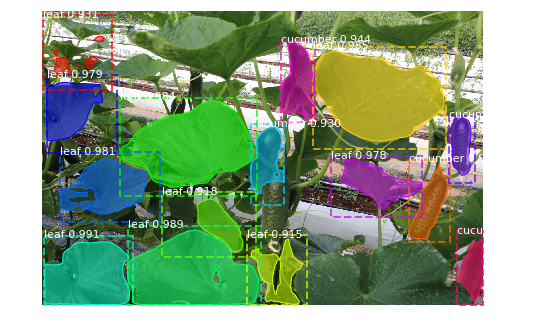

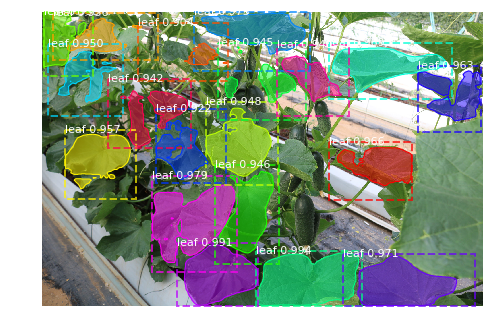

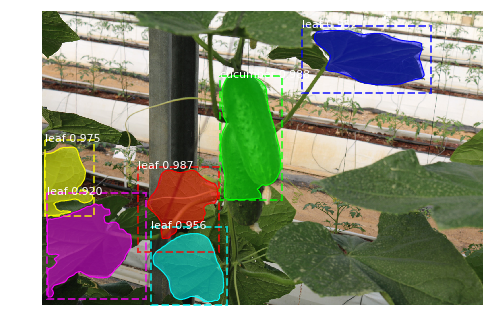

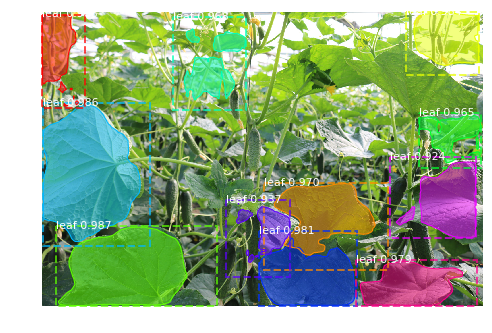

In [4]:


def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


# Training dataset
# asher todo: find a workaround to get rid of initiating a dataset object here
dataset_train = genDataset( ROOT_DIR + '/cucu_train/cucumbers_objects', 
                            ROOT_DIR + '/cucu_train/leaves_objects',
                            ROOT_DIR + '/cucu_train/flower_objects',
                        ROOT_DIR + '/cucu_train/background_folder', config)
dataset_train.load_shapes(100, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

tests_location = ROOT_DIR + "/cucu_train/simple_test/1024/"
for filename in sorted(os.listdir(tests_location)):
    
    testImage = os.path.join(tests_location,filename)
    t = cv2.cvtColor(cv2.imread(testImage), cv2.COLOR_BGR2RGB)
    results = model.detect([t], verbose=1)
    r = results[0]
    img = visualize.display_instances(t, r['rois'], r['masks'], r['class_ids'] ,dataset_train.class_names, r['scores'], ax=get_ax())
    t= dataset_train.class_names
    # save images for presentations
    # cm = plt.get_cmap('gist_earth', lut=50)

    img = Image.fromarray(img)
    img.save(str(filename) + "_inf" + ".png", "PNG")

    # apply color map to masks
    # img = (cm(images[1])[:, :, :3] * 255).astype(np.uint8)
    # img = Image.fromarray(img)
    # img.save(str(image_id) + "_mask_leaf" + ".png", "PNG")

    # img = (cm(images[2])[:, :, :3] * 255).astype(np.uint8)
    # img = Image.fromarray(img)
    # img.save(str(image_id) + "_mask_fruit" + ".png", "PNG")

    # img = (cm(images[3])[:, :, :3] * 255).astype(np.uint8)
    # img = Image.fromarray(img)
    # img.save(str(image_id) + "_mask_flower" + ".png", "PNG")
    print(t)




In [ ]:




# # Compute VOC-Style mAP @ IoU=0.5
# # Running on 10 images. Increase for better accuracy.
# image_ids = np.random.choice(dataset_val.image_ids, 100)
# APs = []
# for image_id in image_ids:
#     # Load image and ground truth data
#     image, image_meta, gt_class_id, gt_bbox, gt_mask =        modellib.load_image_gt(dataset_val, inference_config,
#                                image_id, use_mini_mask=False)
#     molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
#     # Run object detection
#     results = model.detect([image], verbose=0)
#     r = results[0]
#     # Compute AP
#     AP, precisions, recalls, overlaps =        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
#                          r["rois"], r["class_ids"], r["scores"], r['masks'])
#     APs.append(AP)
    
# print("mAP: ", np.mean(APs))






